In [3]:
# assign the data 
from dataclasses import dataclass
from typing import List
from datetime import datetime

@dataclass
class Waypoint:
    x: float
    y: float
    z: float
    timestamp: datetime

@dataclass
class DroneMission:
    id: str
    waypoints: List[Waypoint]

In [5]:
# Conflict Detection

from math import sqrt

def euclidean_distance(p1, p2):
    return sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2 + (p1.z - p2.z)**2)

def check_conflict(primary: DroneMission, others: List[DroneMission], time_thresh=5, safety_radius=10):
    conflicts = []
    for other in others:
        for wp1 in primary.waypoints:
            for wp2 in other.waypoints:
                if abs((wp1.timestamp - wp2.timestamp).total_seconds()) <= time_thresh:
                    distance = euclidean_distance(wp1, wp2)
                    if distance < safety_radius:
                        conflicts.append({
                            'conflict_with': other.id,
                            'time': wp1.timestamp.isoformat(),
                            'location': (wp1.x, wp1.y, wp1.z),
                            'distance': distance
                        })
    return ("conflict detected", conflicts) if conflicts else ("clear", [])

In [7]:
#3D Static Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_missions(primary, others):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = [wp.x for wp in primary.waypoints]
    y = [wp.y for wp in primary.waypoints]
    z = [wp.z for wp in primary.waypoints]
    ax.plot(x, y, z, label='Primary Drone', color='blue')

    for drone in others:
        x = [wp.x for wp in drone.waypoints]
        y = [wp.y for wp in drone.waypoints]
        z = [wp.z for wp in drone.waypoints]
        ax.plot(x, y, z, label=f'Drone {drone.id}', linestyle='--')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()
    plt.show()


In [9]:
# 4D Animation

from matplotlib.animation import FuncAnimation

def animate_4d(primary, others):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    def get_coords(drone):
        return [wp.x for wp in drone.waypoints], [wp.y for wp in drone.waypoints], [wp.z for wp in drone.waypoints], [wp.timestamp for wp in drone.waypoints]

    px, py, pz, pt = get_coords(primary)
    ox, oy, oz, ot = get_coords(others[0])  # only animate first simulated drone

    line_p, = ax.plot([], [], [], color='blue', label='Primary')
    line_o, = ax.plot([], [], [], color='red', linestyle='--', label='Simulated')

    ax.set_xlim(0, max(px + ox) + 10)
    ax.set_ylim(0, max(py + oy) + 10)
    ax.set_zlim(0, max(pz + oz) + 10)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    def update(frame):
        line_p.set_data(px[:frame], py[:frame])
        line_p.set_3d_properties(pz[:frame])
        line_o.set_data(ox[:frame], oy[:frame])
        line_o.set_3d_properties(oz[:frame])
        return line_p, line_o

    anim = FuncAnimation(fig, update, frames=len(px), interval=1000, blit=False)
    plt.show()
    return anim


Status: conflict detected
{'conflict_with': 'S1', 'time': '2025-04-14T10:05:00', 'location': (100, 100, 10), 'distance': 7.0710678118654755}


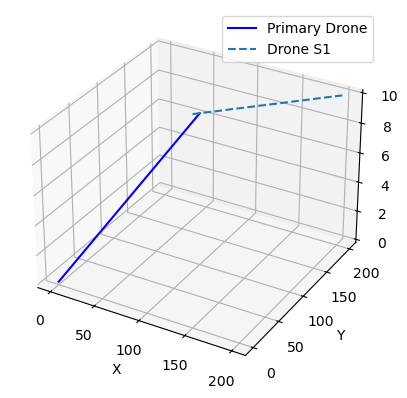

In [11]:
#  Sample Mission Data + Runner
import json

sample_json = """
[
  {
    "id": "P1",
    "waypoints": [
      {"x": 0, "y": 0, "z": 0, "timestamp": "2025-04-14T10:00:00"},
      {"x": 100, "y": 100, "z": 10, "timestamp": "2025-04-14T10:05:00"}
    ]
  },
  {
    "id": "S1",
    "waypoints": [
      {"x": 95, "y": 95, "z": 10, "timestamp": "2025-04-14T10:05:00"},
      {"x": 200, "y": 200, "z": 10, "timestamp": "2025-04-14T10:10:00"}
    ]
  }
]
"""

def parse_missions(json_str):
    raw = json.loads(json_str)
    missions = []
    for m in raw:
        waypoints = [
            Waypoint(x=w['x'], y=w['y'], z=w['z'], timestamp=datetime.fromisoformat(w['timestamp']))
            for w in m['waypoints']
        ]
        missions.append(DroneMission(id=m['id'], waypoints=waypoints))
    return missions

# Run
missions = parse_missions(sample_json)
primary = missions[0]
others = missions[1:]

status, details = check_conflict(primary, others)
print("Status:", status)
if details:
    for d in details:
        print(d)

plot_missions(primary, others)
# animate_4d(primary, others)  # Uncomment to see 4D animation
